In [12]:
import os

# Dataset root path
data_dir = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")


✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/LICENSE.txt
8. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publ

In [13]:
# --- Add these lines at top-level (no indentation) ---
!pip install ptflops

from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(
    model, 
    (X_train_t.shape[1], X_train_t.shape[2]),  # (seq_len, input_size)
    as_strings=True, 
    print_per_layer_stat=False
)
print(f"✅ Model Complexity: {macs} MACs | Params: {params}")


✅ Model Complexity: 18.72 MMac MACs | Params: 1.59 M


In [14]:
!pip install wfdb
import os
import pandas as pd
import numpy as np
import wfdb
import ast

# === Step 1: Define loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signal data from PTB-XL based on sampling rate.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)


# === Step 2: Setup paths and sampling rate ===
path = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100


# === Step 3: Load metadata and convert scp_codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))


# === Step 4: Load signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"Loaded {len(X)} ECG samples.")


# === Step 5: Load SCP statements for diagnostic mapping ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements


# === Step 6: Map SCP codes → diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    """
    Given a dictionary of SCP codes (like {'NORM': 100.0, 'IMI': 50.0}),
    return a list of diagnostic superclasses, e.g. ['NORM'] or ['MI'].
    """
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)


# === Step 7: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # ensure correct alignment


# === Step 8: Simplify label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])


# === Final Output ===
print(f"\n✅ Filtered samples: {len(X_filtered)}")
print("📊 Label distribution:\n")
print(Y_filtered['diagnostic_superclass'].value_counts())

# === Optional: save for reuse ===
# np.save('X_filtered.npy', X_filtered)
# Y_filtered.to_csv('Y_filtered.csv')

Loading ECG signal data...
Loaded 21799 ECG samples.

✅ Filtered samples: 16244
📊 Label distribution:

diagnostic_superclass
NORM    9069
MI      2532
STTC    2400
CD      1708
HYP      535
Name: count, dtype: int64


In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# === Step 1: Prepare data ===
X = X_filtered
y = Y_filtered['diagnostic_superclass']

# === Step 2: Split into train (70%) and temp (30%) ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,       # remaining 30% for val + test
    random_state=42,
    stratify=y
)

# === Step 3: Split temp (30%) into validation (10%) and test (20%) ===
# 10% / 30% = 0.3333 → 33.33% of temp will be validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.6667,     # 2/3 of 30% → 20% of total
    random_state=42,
    stratify=y_temp
)

# === Step 4: Display summary ===
print("✅ Split Summary:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X):.2%})")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(X):.2%})")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X):.2%})")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\nShapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


✅ Split Summary:
Train: 11370 samples (70.00%)
Validation: 1624 samples (10.00%)
Test: 3250 samples (20.01%)

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    6348
MI      1772
STTC    1680
CD      1196
HYP      374
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    907
MI      253
STTC    240
CD      170
HYP      54
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    1814
MI       507
STTC     480
CD       342
HYP      107
Name: count, dtype: int64

Shapes:
X_train: (11370, 1000, 12)
X_val: (1624, 1000, 12)
X_test: (3250, 1000, 12)


✅ Data Split: Train 70.00%, Val 10.00%, Test 20.01%
Epoch 1/50 | Train Loss: 1.2558 | Val Loss: 1.2105 | Val Acc: 57.20%
Epoch 2/50 | Train Loss: 1.1216 | Val Loss: 1.1895 | Val Acc: 57.45%
Epoch 3/50 | Train Loss: 0.9127 | Val Loss: 1.2132 | Val Acc: 55.23%
Epoch 4/50 | Train Loss: 0.6146 | Val Loss: 1.3875 | Val Acc: 52.71%
Epoch 5/50 | Train Loss: 0.3425 | Val Loss: 1.7715 | Val Acc: 50.92%
Epoch 6/50 | Train Loss: 0.1834 | Val Loss: 2.2031 | Val Acc: 52.52%
Epoch 7/50 | Train Loss: 0.0983 | Val Loss: 2.4518 | Val Acc: 49.01%
Epoch 8/50 | Train Loss: 0.0676 | Val Loss: 2.6368 | Val Acc: 52.46%
Epoch 9/50 | Train Loss: 0.0449 | Val Loss: 2.9849 | Val Acc: 51.29%
Epoch 10/50 | Train Loss: 0.0451 | Val Loss: 3.0131 | Val Acc: 50.25%
Epoch 11/50 | Train Loss: 0.0394 | Val Loss: 2.9480 | Val Acc: 48.95%
Epoch 12/50 | Train Loss: 0.0297 | Val Loss: 3.2413 | Val Acc: 50.37%
Epoch 13/50 | Train Loss: 0.0218 | Val Loss: 3.3372 | Val Acc: 52.09%
Epoch 14/50 | Train Loss: 0.0251 | Val Loss: 3.

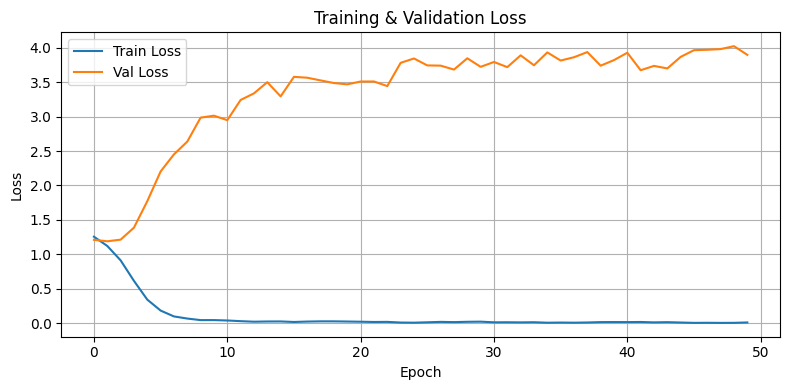

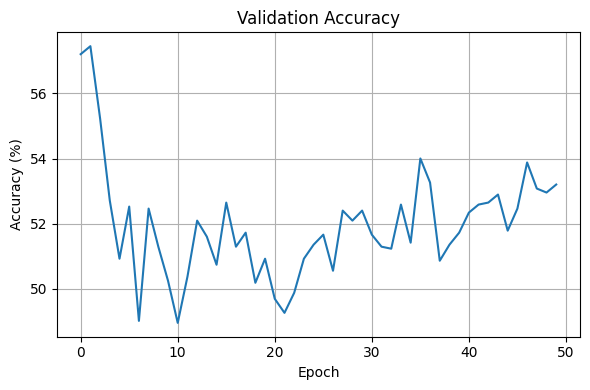


✅ Final Test Accuracy: 52.68%
⏱ Test wall-clock time: 0.23 s total | 0.000070 s/sample

Classification Report:
               precision    recall  f1-score   support

          CD       0.29      0.28      0.29       342
         HYP       0.03      0.02      0.02       107
          MI       0.32      0.28      0.30       507
        NORM       0.66      0.74      0.70      1814
        STTC       0.33      0.25      0.29       480

    accuracy                           0.53      3250
   macro avg       0.33      0.32      0.32      3250
weighted avg       0.50      0.53      0.51      3250


Per-Class Accuracy (%):
  CD: 28.36%
  HYP: 1.87%
  MI: 27.61%
  NORM: 74.48%
  STTC: 25.42%


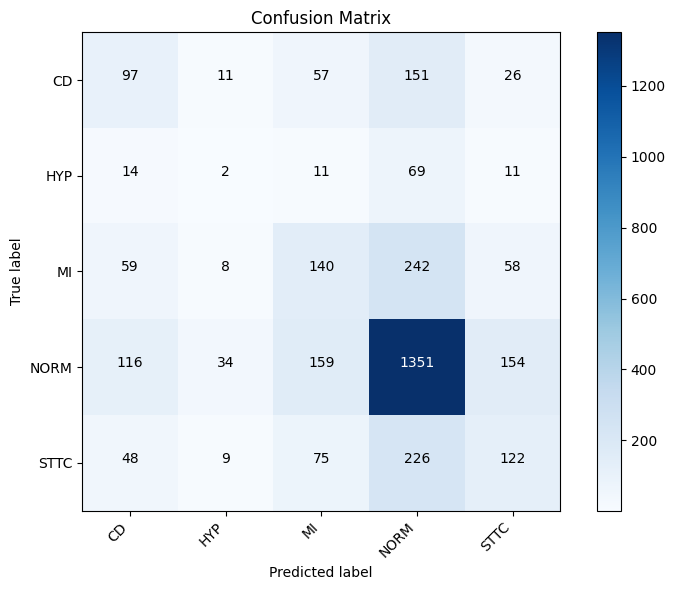


Top Confused Class Pairs:
  MI → NORM : 242
  STTC → NORM : 226
  NORM → MI : 159
  NORM → STTC : 154
  CD → NORM : 151
  NORM → CD : 116
  STTC → MI : 75
  HYP → NORM : 69
  MI → CD : 59
  MI → STTC : 58

ROC–AUC (macro): 0.6435, (micro): 0.7794
  CD: AUC = 0.6315
  HYP: AUC = 0.5810
  MI: AUC = 0.6360
  NORM: AUC = 0.6768
  STTC: AUC = 0.6924


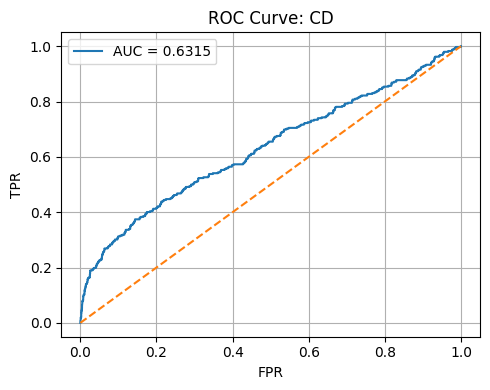

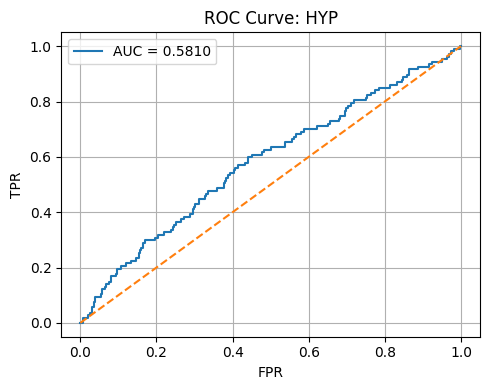

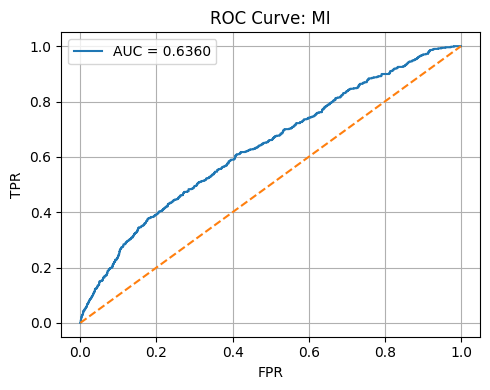

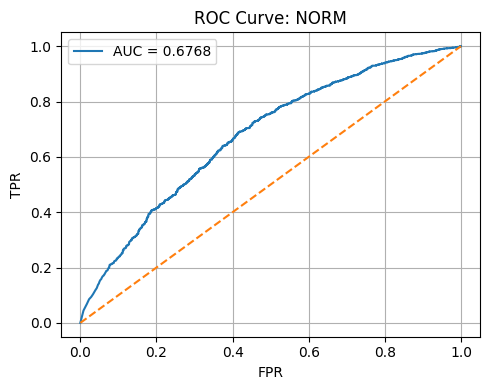

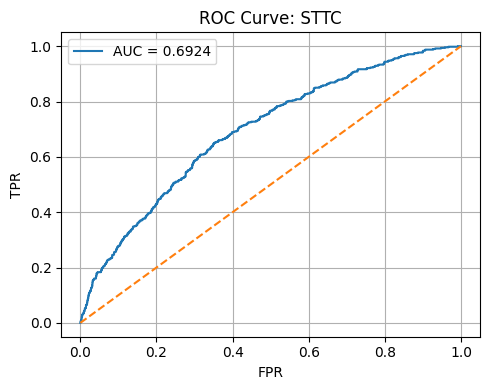


Model Complexity: Params=1,553,669, MACs=18,691,333, ≈0.0374 GFLOPs per inference

📊 Saved evaluation_summary.csv
✅ All plots and metrics saved to disk successfully.


In [16]:
# ============================================================
# ECG Classification using LSTM + Evaluation Metrics (Full)
# ============================================================

import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 1. Data Preparation
# ============================================================

# --- Split into 70% train + 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.30,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# --- Split 30% temp into 10% val + 20% test (ratio 1:2)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.6667,    # 2/3 of 30% = 20%
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# --- Reshape for LSTM (batch, timesteps, features)
X_train_lstm = np.transpose(X_train, (0, 2, 1))
X_val_lstm   = np.transpose(X_val, (0, 2, 1))
X_test_lstm  = np.transpose(X_test, (0, 2, 1))

# --- Encode Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# --- Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_lstm, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# --- Datasets and DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ============================================================
# 2. Define LSTM Model
# ============================================================

class ECG_LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, n_classes)  # bidirectional → hidden*2

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

# ============================================================
# 3. Training Setup
# ============================================================

n_classes = len(le.classes_)
model = ECG_LSTM(input_size=X_train_tensor.shape[2], n_classes=n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ============================================================
# 4. Training Loop with Tracking
# ============================================================

EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

start_train_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, yb)
            running_val_loss += loss.item() * Xb.size(0)
            _, predicted = preds.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

end_train_time = time.time()
train_time = end_train_time - start_train_time
print(f"\n✅ Training complete in {train_time:.2f} seconds.")

# ============================================================
# 5. Save Model
# ============================================================

torch.save(model.state_dict(), "ecg_lstm_70_10_20.pt")
print("✅ Model saved as ecg_lstm_70_10_20.pt")

# ============================================================
# 6. Training / Validation Curves
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("val_accuracy_curve.png")
plt.show()

# ============================================================
# 7. Final Test Evaluation
# ============================================================

model.eval()
all_preds, all_probs, all_labels = [], [], []

start_test_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        _, predicted = logits.max(1)
        all_preds.append(predicted.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())
end_test_time = time.time()

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)
y_prob = np.concatenate(all_probs)

test_acc = 100.0 * (y_pred == y_true).mean()
test_time = end_test_time - start_test_time

print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")
print(f"⏱ Test wall-clock time: {test_time:.2f} s total | {(test_time/len(y_true)):.6f} s/sample")

# ============================================================
# 8. Metrics: Precision, Recall, F1, Per-Class Accuracy
# ============================================================

report = classification_report(y_true, y_pred, target_names=le.classes_)
print("\nClassification Report:\n", report)

per_class_acc = {}
for i, cls in enumerate(le.classes_):
    idx = (y_true == i)
    per_class_acc[cls] = 100.0 * (y_pred[idx] == y_true[idx]).mean()
print("\nPer-Class Accuracy (%):")
for cls, acc in per_class_acc.items():
    print(f"  {cls}: {acc:.2f}%")

# ============================================================
# 9. Confusion Matrix + Failure Modes
# ============================================================

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.to_csv("confusion_matrix.csv")

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45, ha="right")
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]}", ha="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# --- Top confused pairs ---
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
pairs = [(i, j, cm_no_diag[i, j]) for i in range(len(le.classes_)) for j in range(len(le.classes_))]
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
print("\nTop Confused Class Pairs:")
for i, j, cnt in pairs_sorted[:10]:
    if cnt > 0:
        print(f"  {le.classes_[i]} → {le.classes_[j]} : {cnt}")

# ============================================================
# 10. ROC–AUC (One-vs-Rest)
# ============================================================

n_classes = len(le.classes_)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
micro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='micro', multi_class='ovr')

print(f"\nROC–AUC (macro): {macro_roc_auc:.4f}, (micro): {micro_roc_auc:.4f}")
for i in range(n_classes):
    print(f"  {le.classes_[i]}: AUC = {roc_auc[i]:.4f}")

for i in range(n_classes):
    plt.figure(figsize=(5,4))
    plt.plot(fpr[i], tpr[i], label=f"AUC = {roc_auc[i]:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve: {le.classes_[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"roc_{le.classes_[i]}.png")
    plt.show()

# ============================================================
# 11. GFLOPs Estimation (optional)
# ============================================================

try:
    from ptflops import get_model_complexity_info
    model_cpu = model.to('cpu')
    timesteps = X_train_tensor.shape[1]
    features = X_train_tensor.shape[2]
    macs, params = get_model_complexity_info(
        model_cpu, (timesteps, features), as_strings=False, print_per_layer_stat=False
    )
    gflops = (macs * 2) / 1e9
    print(f"\nModel Complexity: Params={params:,}, MACs={macs:,}, ≈{gflops:.4f} GFLOPs per inference")
    model = model.to(device)
except Exception as e:
    print("\n⚠️ GFLOPs estimation skipped (install `ptflops` for automatic analysis).")

# ============================================================
# 12. Save Summary
# ============================================================

summary = {
    "Train_time_s": train_time,
    "Test_time_s": test_time,
    "Test_acc_%": test_acc,
    "Macro_ROC_AUC": macro_roc_auc,
    "Micro_ROC_AUC": micro_roc_auc
}
pd.Series(summary).to_csv("evaluation_summary.csv")
print("\n📊 Saved evaluation_summary.csv")
print("✅ All plots and metrics saved to disk successfully.")


✅ Data Split: Train 70.00%, Val 10.00%, Test 20.01%
Epoch 1/50 | Train Loss: 1.2922 | Val Loss: 1.2059 | Val Acc: 56.96%
Epoch 2/50 | Train Loss: 1.1995 | Val Loss: 1.1808 | Val Acc: 57.82%
Epoch 3/50 | Train Loss: 1.1045 | Val Loss: 1.1585 | Val Acc: 57.51%
Epoch 4/50 | Train Loss: 1.0047 | Val Loss: 1.2029 | Val Acc: 57.02%
Epoch 5/50 | Train Loss: 0.8975 | Val Loss: 1.2137 | Val Acc: 56.22%
Epoch 6/50 | Train Loss: 0.7821 | Val Loss: 1.2834 | Val Acc: 56.59%
Epoch 7/50 | Train Loss: 0.6737 | Val Loss: 1.3829 | Val Acc: 54.37%
Epoch 8/50 | Train Loss: 0.5753 | Val Loss: 1.4254 | Val Acc: 56.90%
Epoch 9/50 | Train Loss: 0.4876 | Val Loss: 1.6134 | Val Acc: 54.68%
Epoch 10/50 | Train Loss: 0.4184 | Val Loss: 1.6582 | Val Acc: 51.79%
Epoch 11/50 | Train Loss: 0.3784 | Val Loss: 1.7969 | Val Acc: 53.26%
Epoch 12/50 | Train Loss: 0.3186 | Val Loss: 1.9014 | Val Acc: 54.43%
Epoch 13/50 | Train Loss: 0.2781 | Val Loss: 1.9402 | Val Acc: 53.45%
Epoch 14/50 | Train Loss: 0.2747 | Val Loss: 1.

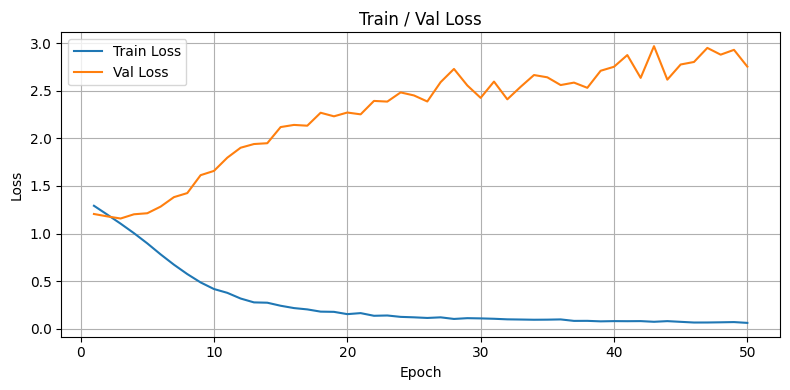

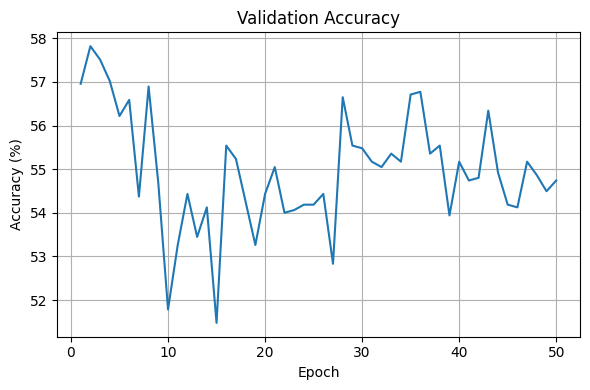


✅ Test Accuracy: 54.95%
⏱ Test inference time total: 0.2290 s | per-sample: 0.000070 s

Classification Report:
               precision    recall  f1-score   support

          CD     0.4335    0.2193    0.2913       342
         HYP     0.0833    0.0093    0.0168       107
          MI     0.2929    0.3195    0.3057       507
        NORM     0.6522    0.8010    0.7190      1814
        STTC     0.3345    0.1979    0.2487       480

    accuracy                         0.5495      3250
   macro avg     0.3593    0.3094    0.3163      3250
weighted avg     0.5075    0.5495    0.5169      3250


Per-class accuracy (%):
  CD: 21.93%
  HYP: 0.93%
  MI: 31.95%
  NORM: 80.10%
  STTC: 19.79%
Saved confusion matrix CSV to ecgnet_outputs/confusion_matrix.csv


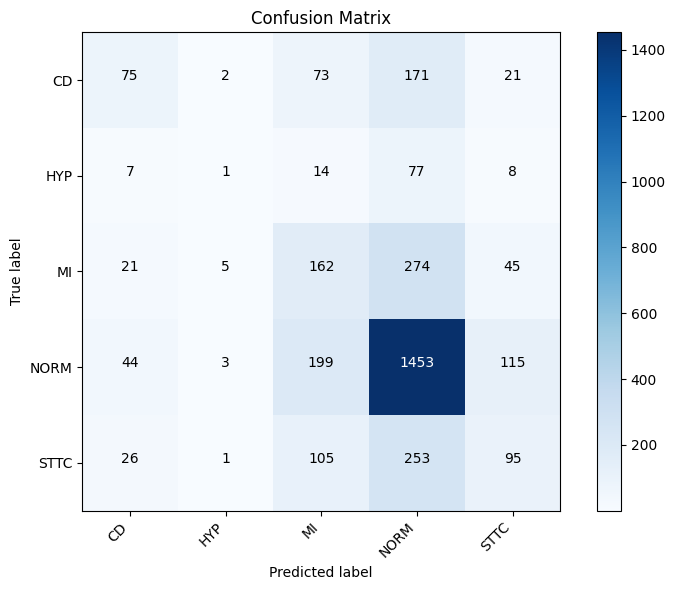


Top confused class pairs (true -> pred):
  MI -> NORM : 274
  STTC -> NORM : 253
  NORM -> MI : 199
  CD -> NORM : 171
  NORM -> STTC : 115
  STTC -> MI : 105
  HYP -> NORM : 77
  CD -> MI : 73
  MI -> STTC : 45
  NORM -> CD : 44

ROC-AUC macro: 0.6471570456001501, micro: 0.8084536804733728


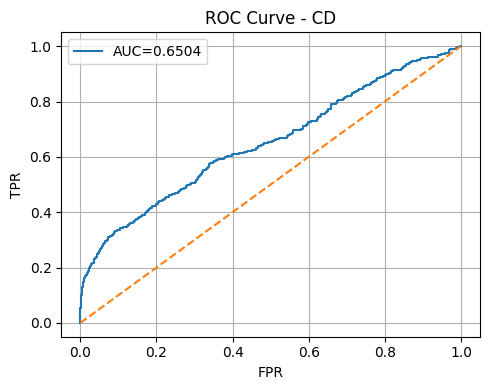

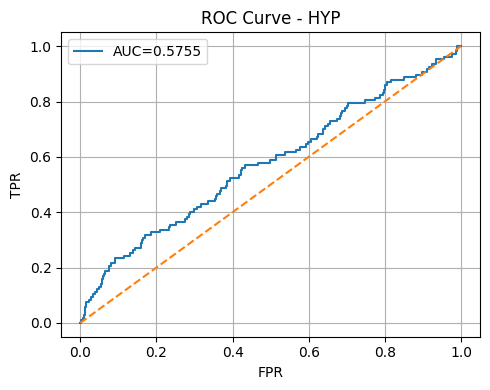

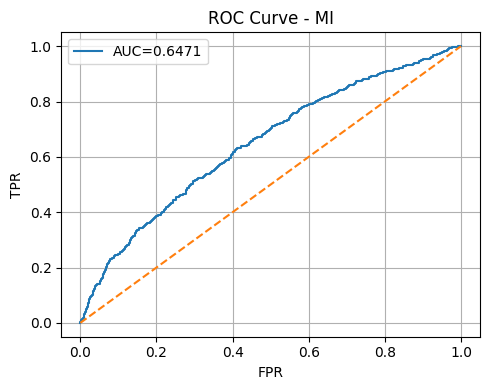

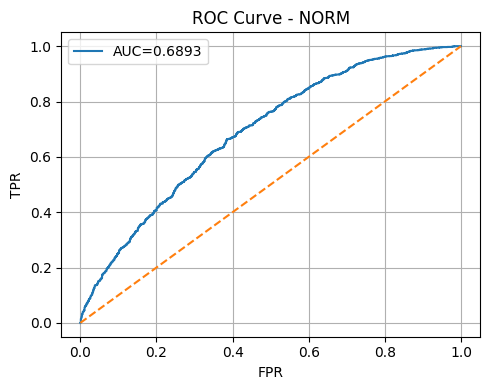

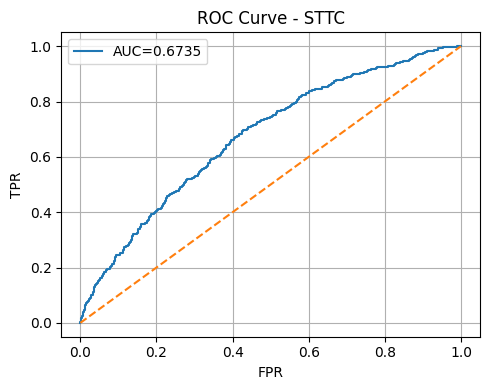

Saved per-class metrics to ecgnet_outputs/per_class_metrics.csv

Microbenchmark: avg_run_time=0.002601s, avg_per_sample=0.000041s

Model complexity: params=593,861, MACs=4,680,197 -> ≈0.0094 GFLOPs per inference

Saved evaluation summary to ecgnet_outputs/evaluation_summary.csv
✅ All done. Output files in ./ecgnet_outputs/


In [17]:
# ============================================================
# ECGNet (1D CNN) Full Training + Evaluation Script
# ============================================================
# Assumes: X_filtered (np.array: n_samples x n_leads x n_timesteps)
#          Y_filtered['diagnostic_superclass'] iterable of labels
# ============================================================

import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ---------------------------
# 1) Data split (70/10/20)
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.30,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.6667,    # 2/3 of 30% = 20%
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# ---------------------------
# 2) Prepare tensors for Conv1D
# PyTorch Conv1d expects (batch, channels, length)
# We'll set channels = n_leads, length = n_timesteps
# Start inputs shape assumed: (n_samples, n_leads, n_timesteps)
# ---------------------------
def to_conv_input(X):
    # ensure numpy
    X = np.asarray(X)
    # if X shape is (n_samples, n_timesteps, n_leads) transpose:
    if X.ndim == 3 and X.shape[1] == X_filtered.shape[2] and X.shape[2] == X_filtered.shape[1]:
        X = np.transpose(X, (0, 2, 1))
    return X.astype(np.float32)

X_train_conv = to_conv_input(X_train)
X_val_conv   = to_conv_input(X_val)
X_test_conv  = to_conv_input(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_conv, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_conv, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_conv, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3) ECGNet architecture (1D CNN)
# A compact, effective architecture for ECG 1D signals.
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=7, stride=1, padding=None, pool_k=2, dropout=0.1):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool1d(pool_k) if pool_k else nn.Identity()
        self.drop = nn.Dropout(dropout) if dropout else nn.Identity()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.drop(x)
        return x

class ECGNet(nn.Module):
    def __init__(self, in_channels, n_classes, base_filters=32, dropout=0.3):
        super().__init__()
        # Stem
        self.stem = ConvBlock(in_channels, base_filters, kernel_size=11, pool_k=2, dropout=0.1)

        # Intermediate blocks
        self.block1 = ConvBlock(base_filters, base_filters*2, kernel_size=9, pool_k=2, dropout=0.2)
        self.block2 = ConvBlock(base_filters*2, base_filters*4, kernel_size=7, pool_k=2, dropout=0.25)
        self.block3 = ConvBlock(base_filters*4, base_filters*8, kernel_size=5, pool_k=None, dropout=0.25)

        # Global pooling + classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # output shape (batch, channels, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(base_filters*8, n_classes)

    def forward(self, x):
        # x: (batch, channels, length)
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)  # (batch, channels, 1)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# ---------------------------
# 4) Setup model, loss, optimizer
# ---------------------------
in_channels = X_train_tensor.shape[1]   # number of leads
n_classes = len(le.classes_)

model = ECGNet(in_channels=in_channels, n_classes=n_classes, base_filters=32, dropout=0.4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optional: scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# ---------------------------
# 5) Train (record metrics & curves)
# ---------------------------
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

start_train_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    avg_train_loss = running_loss / max(1, len(train_loader.dataset))
    train_losses.append(avg_train_loss)

    # validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            running_val_loss += loss.item() * Xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = running_val_loss / max(1, len(val_loader.dataset))
    val_acc = 100.0 * correct / total if total > 0 else 0.0
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
end_train_time = time.time()
train_time = end_train_time - start_train_time
print(f"\n✅ Training finished in {train_time:.2f} seconds.")

# ---------------------------
# 6) Save model weights
# ---------------------------
save_name = "ecgnet_70_10_20.pt"
torch.save(model.state_dict(), save_name)
print(f"✅ Model saved to {save_name}")

# ---------------------------
# 7) Plot training curves
# ---------------------------
os.makedirs("ecgnet_outputs", exist_ok=True)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, EPOCHS+1), val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Train / Val Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("ecgnet_outputs/loss_curve.png")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, EPOCHS+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig("ecgnet_outputs/val_accuracy_curve.png")
plt.show()

# ---------------------------
# 8) Evaluate on test set: predictions, probabilities
# ---------------------------
model.eval()
all_preds, all_probs, all_labels = [], [], []
start_test_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())
end_test_time = time.time()

y_pred = np.concatenate(all_preds) if len(all_preds) else np.array([])
y_prob = np.concatenate(all_probs) if len(all_probs) else np.array([])
y_true = np.concatenate(all_labels) if len(all_labels) else np.array([])

test_time = end_test_time - start_test_time
test_acc = 100.0 * (y_pred == y_true).mean() if y_true.size else 0.0

print(f"\n✅ Test Accuracy: {test_acc:.2f}%")
print(f"⏱ Test inference time total: {test_time:.4f} s | per-sample: {test_time / max(1, len(y_true)):.6f} s")

# ---------------------------
# 9) Classification report + per-class accuracy
# ---------------------------
if y_true.size:
    report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
    print("\nClassification Report:\n", report)

    per_class_acc = {}
    for i, cls in enumerate(le.classes_):
        idx = (y_true == i)
        per_class_acc[cls] = 100.0 * (y_pred[idx] == y_true[idx]).mean() if idx.sum() > 0 else float('nan')
    print("\nPer-class accuracy (%):")
    for cls, acc in per_class_acc.items():
        print(f"  {cls}: {acc:.2f}%")
else:
    print("No test samples found. Skipping classification report.")

# ---------------------------
# 10) Confusion matrix & failure modes
# ---------------------------
if y_true.size:
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    cm_df.to_csv("ecgnet_outputs/confusion_matrix.csv")
    print("Saved confusion matrix CSV to ecgnet_outputs/confusion_matrix.csv")

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
    plt.yticks(tick_marks, le.classes_)
    thresh = cm.max() / 2. if cm.size else 0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("ecgnet_outputs/confusion_matrix.png")
    plt.show()

    # failure modes
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)
    pairs = [(i, j, cm_no_diag[i, j]) for i in range(cm_no_diag.shape[0]) for j in range(cm_no_diag.shape[1])]
    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
    print("\nTop confused class pairs (true -> pred):")
    for (i,j,cnt) in pairs_sorted[:10]:
        if cnt > 0:
            print(f"  {le.classes_[i]} -> {le.classes_[j]} : {cnt}")
else:
    print("No confusion matrix (no test predictions).")

# ---------------------------
# 11) ROC–AUC (one-vs-rest)
# ---------------------------
if y_true.size:
    n_classes = len(le.classes_)
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    # ensure y_prob shape is correct
    if y_prob.shape[0] != y_true.shape[0]:
        print("Warning: mismatch between probabilities and true labels; skipping ROC.")
    else:
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            try:
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            except ValueError:
                fpr[i], tpr[i], roc_auc[i] = None, None, None
        try:
            macro_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
            micro_auc = roc_auc_score(y_true_bin, y_prob, average='micro', multi_class='ovr')
        except Exception:
            macro_auc, micro_auc = None, None

        print(f"\nROC-AUC macro: {macro_auc}, micro: {micro_auc}")
        # plot per-class ROC curves
        for i in range(n_classes):
            if fpr[i] is None:
                continue
            plt.figure(figsize=(5,4))
            plt.plot(fpr[i], tpr[i], label=f"AUC={roc_auc[i]:.4f}")
            plt.plot([0,1], [0,1], '--')
            plt.xlabel('FPR'); plt.ylabel('TPR')
            plt.title(f'ROC Curve - {le.classes_[i]}')
            plt.legend(); plt.grid(True)
            plt.tight_layout()
            safe_name = le.classes_[i].replace(" ", "_")
            plt.savefig(f"ecgnet_outputs/roc_{safe_name}.png")
            plt.show()
else:
    print("Skipping ROC (no test data).")

# ---------------------------
# 12) Per-class precision/recall/f1 numeric CSV
# ---------------------------
if y_true.size:
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    metrics_df = pd.DataFrame({
        "class": le.classes_,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "support": support
    })
    metrics_df.to_csv("ecgnet_outputs/per_class_metrics.csv", index=False)
    print("Saved per-class metrics to ecgnet_outputs/per_class_metrics.csv")

# ---------------------------
# 13) Inference microbenchmark & GFLOPs via ptflops (optional)
# ---------------------------
# microbenchmark
model.eval()
n_runs = 30
try:
    sample_X, _ = next(iter(test_loader))
except Exception:
    sample_X = X_test_tensor[:1] if X_test_tensor.size(0) > 0 else torch.randn(1, in_channels, X_train_tensor.shape[2])
sample_X = sample_X.to(device)
# warmup
with torch.no_grad():
    for _ in range(5):
        _ = model(sample_X)

torch.cuda.synchronize() if torch.cuda.is_available() else None
start = time.time()
with torch.no_grad():
    for _ in range(n_runs):
        _ = model(sample_X)
torch.cuda.synchronize() if torch.cuda.is_available() else None
end = time.time()
avg_run = (end - start) / n_runs
avg_per_sample = avg_run / max(1, sample_X.size(0))
print(f"\nMicrobenchmark: avg_run_time={avg_run:.6f}s, avg_per_sample={avg_per_sample:.6f}s")

# GFLOPs via ptflops if installed
try:
    from ptflops import get_model_complexity_info
    # ptflops expects shape (C, L) for 1D conv models; pass (in_channels, length)
    model_cpu = model.to('cpu')
    length = X_train_tensor.shape[2]
    macs, params = get_model_complexity_info(model_cpu, (in_channels, length), as_strings=False, print_per_layer_stat=False)
    gflops = (macs * 2) / 1e9
    print(f"\nModel complexity: params={params:,}, MACs={macs:,} -> ≈{gflops:.4f} GFLOPs per inference")
    model.to(device)
except Exception as e:
    print("\nNote: ptflops not available or failed. To get GFLOPs install ptflops (`pip install ptflops`) or run your own FLOPs calculation.")
    # Optionally show quick rough flops estimate for conv layers (not provided here)

# ---------------------------
# 14) Save summary CSV
# ---------------------------
summary = {
    "train_time_s": train_time,
    "test_time_s": test_time,
    "test_accuracy_pct": test_acc,
    "avg_inference_time_s_per_sample": avg_per_sample,
    "n_classes": n_classes,
    "n_train": len(X_train_conv),
    "n_val": len(X_val_conv),
    "n_test": len(X_test_conv)
}
pd.Series(summary).to_csv("ecgnet_outputs/evaluation_summary.csv")
print("\nSaved evaluation summary to ecgnet_outputs/evaluation_summary.csv")
print("✅ All done. Output files in ./ecgnet_outputs/")

# ============================================================
# End of script
# ============================================================





✅ Data Split: Train 70.00%, Val 10.00%, Test 20.01%

🚀 Training ResNet-50 on ECG Data...

Epoch 1/50 | Train Loss: 0.9416 | Val Loss: 0.7816 | Val Acc: 73.58%
Epoch 2/50 | Train Loss: 0.7851 | Val Loss: 0.7859 | Val Acc: 76.11%
Epoch 3/50 | Train Loss: 0.6742 | Val Loss: 0.6633 | Val Acc: 77.09%
Epoch 4/50 | Train Loss: 0.6394 | Val Loss: 1.3955 | Val Acc: 71.24%
Epoch 5/50 | Train Loss: 0.6084 | Val Loss: 0.5905 | Val Acc: 78.94%
Epoch 6/50 | Train Loss: 0.5994 | Val Loss: 0.6946 | Val Acc: 77.71%
Epoch 7/50 | Train Loss: 0.5645 | Val Loss: 0.6156 | Val Acc: 77.16%
Epoch 8/50 | Train Loss: 0.5600 | Val Loss: 0.5649 | Val Acc: 80.60%
Epoch 9/50 | Train Loss: 0.5558 | Val Loss: 0.5784 | Val Acc: 79.86%
Epoch 10/50 | Train Loss: 0.5384 | Val Loss: 0.5488 | Val Acc: 81.16%
Epoch 11/50 | Train Loss: 0.5173 | Val Loss: 0.5230 | Val Acc: 81.83%
Epoch 12/50 | Train Loss: 0.5093 | Val Loss: 0.5464 | Val Acc: 81.47%
Epoch 13/50 | Train Loss: 0.4900 | Val Loss: 0.5670 | Val Acc: 82.70%
Epoch 14/

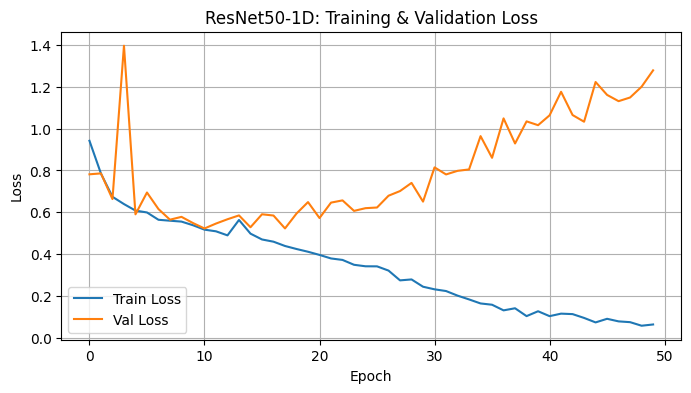

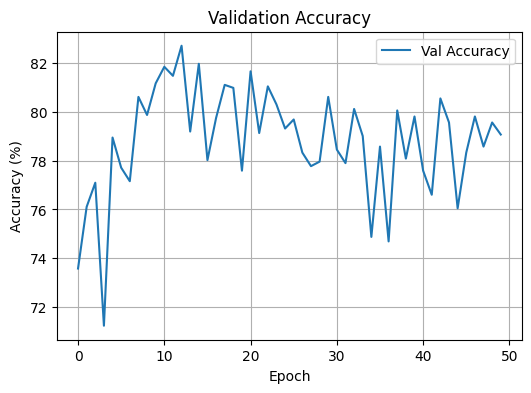


✅ Final Test Accuracy: 79.05%
⏱ Test time: 1.34s

Classification Report:
              precision    recall  f1-score   support

          CD       0.89      0.62      0.73       342
         HYP       0.47      0.25      0.33       107
          MI       0.78      0.67      0.72       507
        NORM       0.80      0.94      0.86      1814
        STTC       0.74      0.60      0.66       480

    accuracy                           0.79      3250
   macro avg       0.74      0.62      0.66      3250
weighted avg       0.79      0.79      0.78      3250

  CD: 61.99%
  HYP: 25.23%
  MI: 67.26%
  NORM: 93.72%
  STTC: 60.21%


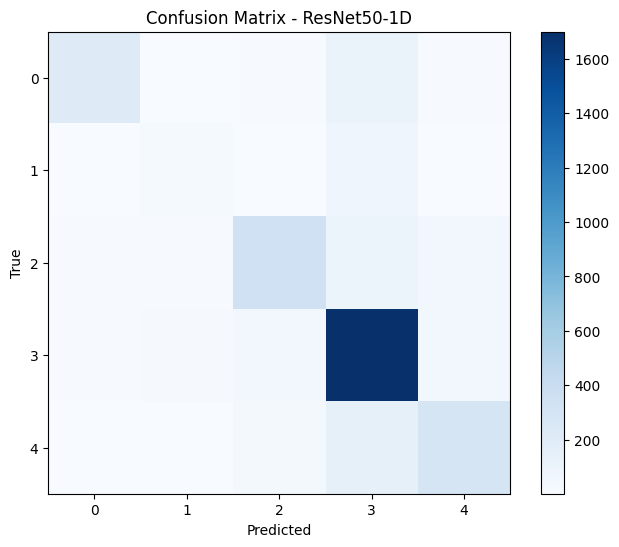


ROC–AUC (macro): 0.9131
Install ptflops (`pip install ptflops`) to measure GFLOPs.

✅ Saved summary to resnet50_eval_summary.csv
✅ Done.


In [18]:
# ============================================================
# ECG Classification with 1D ResNet-50
# ============================================================

import os, time, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 1️⃣ DATA PREPARATION
# ============================================================

# Split 70/10/20
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.30, random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6667,
    random_state=42, stratify=y_temp
)
print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# Conv1D expects (batch, channels, length)
def to_conv_input(X):
    X = np.asarray(X)
    # ensure shape (n_samples, n_channels, length)
    if X.shape[1] < X.shape[2]:
        return X.astype(np.float32)
    else:
        return np.transpose(X, (0, 2, 1)).astype(np.float32)

X_train_c = to_conv_input(X_train)
X_val_c   = to_conv_input(X_val)
X_test_c  = to_conv_input(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Tensors
X_train_t = torch.tensor(X_train_c, dtype=torch.float32)
y_train_t = torch.tensor(y_train_enc, dtype=torch.long)
X_val_t   = torch.tensor(X_val_c, dtype=torch.float32)
y_val_t   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_t  = torch.tensor(X_test_c, dtype=torch.float32)
y_test_t  = torch.tensor(y_test_enc, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ============================================================
# 2️⃣ DEFINE 1D RESNET-50 ARCHITECTURE
# ============================================================

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

class Bottleneck1D(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out); out = self.relu(out)
        out = self.conv3(out); out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=5, in_channels=12):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = nn.BatchNorm1d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet50_1d(in_channels, num_classes):
    return ResNet1D(Bottleneck1D, [3, 4, 6, 3], num_classes=num_classes, in_channels=in_channels)

# ============================================================
# 3️⃣ TRAINING SETUP
# ============================================================

in_channels = X_train_t.shape[1]
n_classes = len(le.classes_)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50_1d(in_channels, n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

print("\n🚀 Training ResNet-50 on ECG Data...\n")
start_train_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            _, predicted = torch.max(preds.data, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

end_train_time = time.time()
train_time = end_train_time - start_train_time
print(f"\n✅ Training complete in {train_time:.2f}s.")

torch.save(model.state_dict(), "ecg_resnet50_70_10_20.pt")
print("✅ Model saved as ecg_resnet50_70_10_20.pt")

# ============================================================
# 4️⃣ PLOT CURVES
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid()
plt.title("ResNet50-1D: Training & Validation Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid()
plt.title("Validation Accuracy")
plt.show()

# ============================================================
# 5️⃣ TEST EVALUATION
# ============================================================
model.eval()
correct, total = 0, 0
y_true, y_pred, y_prob = [], [], []
start_test_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        _, predicted = torch.max(probs, 1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
end_test_time = time.time()
test_time = end_test_time - start_test_time
test_acc = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")
print(f"⏱ Test time: {test_time:.2f}s")

# ============================================================
# 6️⃣ METRICS & REPORTS
# ============================================================
y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Per-class accuracy
for i, cls in enumerate(le.classes_):
    idx = (y_true == i)
    acc = 100 * (y_pred[idx] == y_true[idx]).mean()
    print(f"  {cls}: {acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - ResNet50-1D")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.show()

# ROC–AUC
y_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))
macro_auc = roc_auc_score(y_bin, y_prob, average='macro', multi_class='ovr')
print(f"\nROC–AUC (macro): {macro_auc:.4f}")

# ============================================================
# 7️⃣ FLOPs & TIME
# ============================================================
try:
    from ptflops import get_model_complexity_info
    model_cpu = model.to('cpu')
    L = X_train_t.shape[2]
    macs, params = get_model_complexity_info(model_cpu, (in_channels, L), print_per_layer_stat=False)
    gflops = (macs * 2) / 1e9
    print(f"\nModel Complexity: Params={params:,}, MACs={macs:,} → ≈{gflops:.3f} GFLOPs")
    model = model.to(device)
except:
    print("Install ptflops (`pip install ptflops`) to measure GFLOPs.")

# ============================================================
# 8️⃣ SUMMARY CSV
# ============================================================
summary = {
    "Model": "ResNet50-1D",
    "Train Time (s)": train_time,
    "Test Time (s)": test_time,
    "Test Accuracy (%)": test_acc,
    "Classes": len(le.classes_),
    "Samples": len(X_filtered)
}
pd.Series(summary).to_csv("resnet50_eval_summary.csv")
print("\n✅ Saved summary to resnet50_eval_summary.csv")
print("✅ Done.")


✅ Data Split: Train 70.00%, Val 10.00%, Test 20.01%

🚀 Training RNN on ECG Data...

Epoch [1/50] | Train Loss: 1.2611 | Val Loss: 1.2200 | Val Acc: 57.14%
Epoch [2/50] | Train Loss: 1.1603 | Val Loss: 1.2117 | Val Acc: 57.88%
Epoch [3/50] | Train Loss: 1.0243 | Val Loss: 1.2123 | Val Acc: 55.48%
Epoch [4/50] | Train Loss: 0.7860 | Val Loss: 1.3728 | Val Acc: 53.14%
Epoch [5/50] | Train Loss: 0.5156 | Val Loss: 1.5988 | Val Acc: 51.72%
Epoch [6/50] | Train Loss: 0.3033 | Val Loss: 1.8844 | Val Acc: 51.79%
Epoch [7/50] | Train Loss: 0.1776 | Val Loss: 2.3656 | Val Acc: 52.77%
Epoch [8/50] | Train Loss: 0.1192 | Val Loss: 2.4448 | Val Acc: 51.23%
Epoch [9/50] | Train Loss: 0.0811 | Val Loss: 2.5902 | Val Acc: 50.92%
Epoch [10/50] | Train Loss: 0.0671 | Val Loss: 2.7835 | Val Acc: 51.11%
Epoch [11/50] | Train Loss: 0.0564 | Val Loss: 2.8842 | Val Acc: 49.51%
Epoch [12/50] | Train Loss: 0.0433 | Val Loss: 3.0716 | Val Acc: 51.42%
Epoch [13/50] | Train Loss: 0.0374 | Val Loss: 3.1603 | Val A

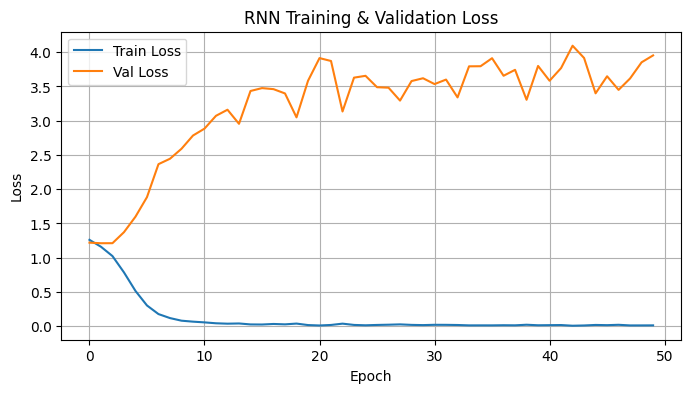

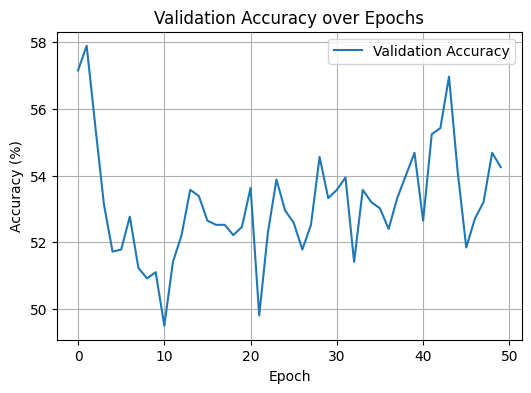


✅ Test Accuracy: 53.45%
⏱ Test Time: 0.24s

Classification Report:
              precision    recall  f1-score   support

          CD       0.34      0.26      0.29       342
         HYP       0.17      0.08      0.11       107
          MI       0.32      0.27      0.29       507
        NORM       0.65      0.77      0.71      1814
        STTC       0.29      0.22      0.25       480

    accuracy                           0.53      3250
   macro avg       0.35      0.32      0.33      3250
weighted avg       0.50      0.53      0.51      3250

  CD: 25.73%
  HYP: 8.41%
  MI: 27.42%
  NORM: 76.96%
  STTC: 21.88%


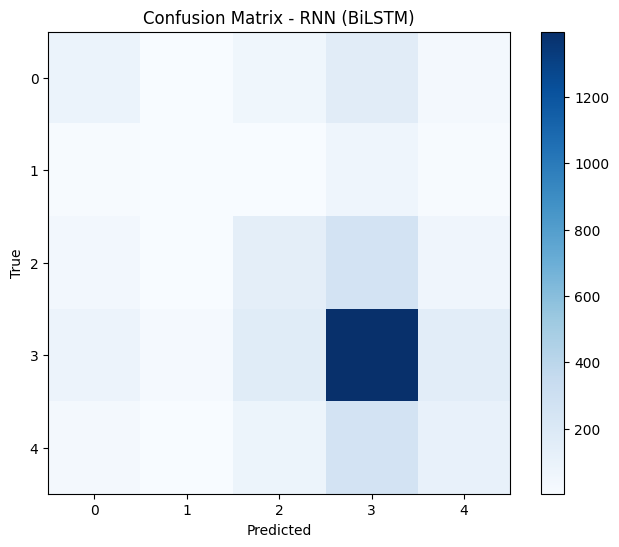


ROC–AUC (macro): 0.6391

✅ Saved summary to rnn_eval_summary.csv
✅ Done.


In [19]:
# ============================================================
# ECG Classification with Bidirectional LSTM (RNN)
# ============================================================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 1️⃣ DATA PREPARATION
# ============================================================

# Split 70 / 10 / 20
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.30, random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6667,
    random_state=42, stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# Convert to numpy arrays
X_train = np.asarray(X_train, dtype=np.float32)
X_val   = np.asarray(X_val, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)

# Shape adjustment for RNN: (batch, seq_len, input_size)
if X_train.shape[1] > X_train.shape[2]:
    X_train = np.transpose(X_train, (0, 2, 1))
    X_val   = np.transpose(X_val, (0, 2, 1))
    X_test  = np.transpose(X_test, (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_enc, dtype=torch.long)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ============================================================
# 2️⃣ MODEL DEFINITION — Bidirectional LSTM
# ============================================================

class ECG_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(ECG_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True,
            dropout=dropout, bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# ============================================================
# 3️⃣ TRAINING SETUP
# ============================================================

input_size = X_train_t.shape[2]
num_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ECG_RNN(input_size=input_size, hidden_size=128, num_layers=2, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

print("\n🚀 Training RNN on ECG Data...\n")
start_train = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            _, pred_class = preds.max(1)
            total += yb.size(0)
            correct += (pred_class == yb).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

end_train = time.time()
train_time = end_train - start_train
print(f"\n✅ Training complete in {train_time:.2f}s.")

torch.save(model.state_dict(), "ecg_rnn_70_10_20.pt")
print("✅ Model saved as ecg_rnn_70_10_20.pt")

# ============================================================
# 4️⃣ PLOTS
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("RNN Training & Validation Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend(); plt.grid(); plt.show()

# ============================================================
# 5️⃣ TEST EVALUATION
# ============================================================

model.eval()
correct, total = 0, 0
y_true, y_pred, y_prob = [], [], []

start_test = time.time()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        _, pred = torch.max(probs, 1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        total += yb.size(0)
        correct += (pred == yb).sum().item()
end_test = time.time()
test_time = end_test - start_test
test_acc = 100 * correct / total

print(f"\n✅ Test Accuracy: {test_acc:.2f}%")
print(f"⏱ Test Time: {test_time:.2f}s")

# ============================================================
# 6️⃣ METRICS & REPORTS
# ============================================================

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Per-class accuracy
for i, cls in enumerate(le.classes_):
    idx = (y_true == i)
    acc = 100 * (y_pred[idx] == y_true[idx]).mean()
    print(f"  {cls}: {acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - RNN (BiLSTM)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.show()

# ROC–AUC
y_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))
macro_auc = roc_auc_score(y_bin, y_prob, average='macro', multi_class='ovr')
print(f"\nROC–AUC (macro): {macro_auc:.4f}")

# ============================================================
# 7️⃣ SUMMARY
# ============================================================
summary = {
    "Model": "RNN (BiLSTM)",
    "Train Time (s)": train_time,
    "Test Time (s)": test_time,
    "Test Accuracy (%)": test_acc,
    "Classes": len(le.classes_),
    "Samples": len(X_filtered)
}
pd.Series(summary).to_csv("rnn_eval_summary.csv")
print("\n✅ Saved summary to rnn_eval_summary.csv")
print("✅ Done.")

